# Transfer learning for images classification

To start, the necessary libraries are loaded.

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import ticker
from random import sample, seed
from seaborn import heatmap
from sklearn.utils import class_weight
from sklearn.metrics import roc_auc_score, roc_curve, auc
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import AUC
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.math import confusion_matrix

## 1. Data exploration

Dataset has been obtained from [Kaggle](https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia), and it is a collection of 5863 X-Ray images (JPEG) belonging to 2 categories: Normal and Pneumonia.

Images are stored inside an archive and therefore extracted.

In [ ]:
!unzip 17810_23812_bundle_archive.zip -d /content/data

Output streaming troncato alle ultime 5000 righe.
  inflating: /content/data/chest_xray/train/NORMAL/IM-0435-0001.jpeg  
  inflating: /content/data/chest_xray/train/NORMAL/IM-0437-0001-0001.jpeg  
  inflating: /content/data/chest_xray/train/NORMAL/IM-0437-0001-0002.jpeg  
  inflating: /content/data/chest_xray/train/NORMAL/IM-0437-0001.jpeg  
  inflating: /content/data/chest_xray/train/NORMAL/IM-0438-0001.jpeg  
  inflating: /content/data/chest_xray/train/NORMAL/IM-0439-0001-0001.jpeg  
  inflating: /content/data/chest_xray/train/NORMAL/IM-0439-0001-0002.jpeg  
  inflating: /content/data/chest_xray/train/NORMAL/IM-0439-0001.jpeg  
  inflating: /content/data/chest_xray/train/NORMAL/IM-0440-0001.jpeg  
  inflating: /content/data/chest_xray/train/NORMAL/IM-0441-0001.jpeg  
  inflating: /content/data/chest_xray/train/NORMAL/IM-0442-0001.jpeg  
  inflating: /content/data/chest_xray/train/NORMAL/IM-0444-0001.jpeg  
  inflating: /content/data/chest_xray/train/NORMAL/IM-0445-0001.jpeg  
  infla

The dataset is organized into 3 folders (train, test, val) and contains subfolders for each image category (Normal, Pneumonia).

In [ ]:
dataset_path = "/content/data/chest_xray/"

def sets_sizes():
  for df_folder in ["train", "val", "test"]:
    print(df_folder)
    for img_class in ["NORMAL", "PNEUMONIA"]:
      files = next(os.walk(dataset_path + df_folder + "/" + img_class))[2]
      print(img_class + ": " + str(len(files)))
    print()

sets_sizes()

train
NORMAL: 1341
PNEUMONIA: 3875

val
NORMAL: 8
PNEUMONIA: 8

test
NORMAL: 234
PNEUMONIA: 390



Validation folder contains only 16 images, but it is safer to enhance it, using a larger dataset. For this reasons, and following the Pareto principle, 20% of images in *train* folder is moved to *val* folder, for both classes.

In [ ]:
train_path = dataset_path + "train/"
valid_path = dataset_path + "val/"
test_path = dataset_path + "test/"

path_normal = train_path + "NORMAL/"
files_normal = next(os.walk(train_path + "NORMAL"))[2]

path_pneumonia = train_path + "PNEUMONIA/"
files_pneumonia = next(os.walk(train_path + "PNEUMONIA"))[2]

seed(123)
normal_to_val = sample(files_normal, int(len(files_normal) * 0.2))
pneumonia_to_val = sample(files_pneumonia, int(len(files_pneumonia) * 0.2))

def move_file(file_list, source_folder, destination_folder):
  for filename in file_list:
    file_to_move = source_folder + "/" + filename
    !mv $file_to_move $destination_folder

move_file(normal_to_val, path_normal, valid_path + "NORMAL")
move_file(pneumonia_to_val, path_pneumonia, valid_path + "PNEUMONIA")

sets_sizes()

train
NORMAL: 1073
PNEUMONIA: 3100

val
NORMAL: 276
PNEUMONIA: 783

test
NORMAL: 234
PNEUMONIA: 390



Let's take a look at some images.

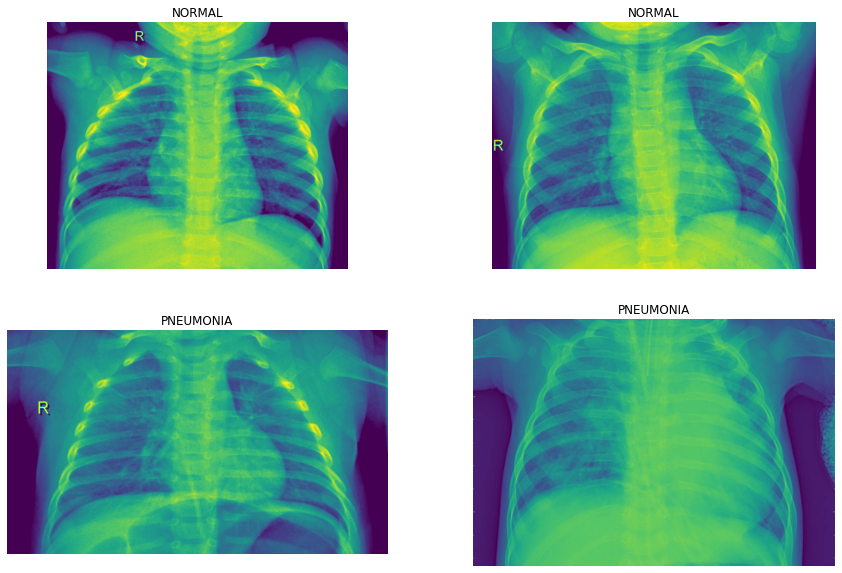

In [ ]:
files_normal = next(os.walk(train_path + "NORMAL"))[2]
files_pneumonia = next(os.walk(train_path + "PNEUMONIA"))[2]

fig, axes = plt.subplots(2, 2, figsize = (15, 10))
axes = axes.ravel()

for i in range(0, 4):
  if i<2:
    img = mpimg.imread(path_normal + files_normal[i])
    axes[i].set_title("NORMAL")
  else:
    img = mpimg.imread(path_pneumonia + files_pneumonia[i])
    axes[i].set_title("PNEUMONIA")

  axes[i].imshow(img)
  axes[i].axis("off")

plt.show()

Let's take a look at the distribution of the target variable.

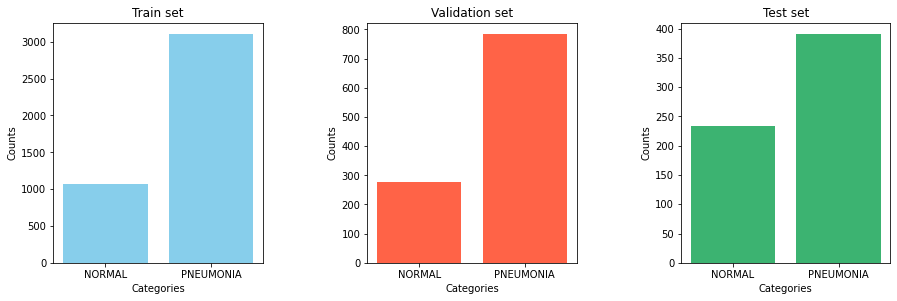

In [ ]:
plt.figure(figsize=(15, 15))

plt.subplot(3, 3, 1)
plt.bar(x=range(0,2), height = [len(next(os.walk(train_path + "NORMAL"))[2]), len(next(os.walk(train_path + "PNEUMONIA"))[2])],
        tick_label=["NORMAL", "PNEUMONIA"], color = "skyblue")
plt.title("Train set")
plt.xlabel("Categories")
plt.ylabel("Counts")

plt.subplot(3, 3, 2)
plt.bar(x=range(0,2), height = [len(next(os.walk(valid_path + "NORMAL"))[2]), len(next(os.walk(valid_path + "PNEUMONIA"))[2])],
        tick_label=["NORMAL", "PNEUMONIA"], color = "tomato")
plt.title("Validation set")
plt.xlabel("Categories")
plt.ylabel("Counts")

plt.subplot(3, 3, 3)
plt.bar(x=range(0,2), height = [len(next(os.walk(test_path + "NORMAL"))[2]), len(next(os.walk(test_path + "PNEUMONIA"))[2])],
        tick_label=["NORMAL", "PNEUMONIA"], color = "mediumseagreen")
plt.title("Test set")
plt.xlabel("Categories")
plt.ylabel("Counts")

plt.subplots_adjust(wspace=0.5)
plt.show()

The two classes are not equally distributed, so it could be necessary to balance them when the model is trained.

## 2. Data pre-processing

Since this is a binary classification problem, class "Normal" is mapped to 0, while class "Pneumonia" is mapped to 1.

Images have not the same size, anyway they are resized to 224x224. Also, some pre-processing is done to them, to prevent overfitting and improve the model accuracy, this technique is called data augmentation.

In [ ]:
train_batch_size = 64
valid_batch_size = 64
test_batch_size = 32
image_h = 224
image_w = 224

train_datagen = ImageDataGenerator(rescale=1/255.,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   vertical_flip=False)

train_generator = train_datagen.flow_from_directory(directory=train_path,
                                                    target_size=(image_h, image_w),
                                                    batch_size=train_batch_size,
                                                    classes=["NORMAL", "PNEUMONIA"],
                                                    class_mode="binary")

valid_datagen = ImageDataGenerator(rescale=1/255.)
valid_generator = valid_datagen.flow_from_directory(directory=valid_path,
                                                    target_size=(image_h, image_w),
                                                    batch_size=valid_batch_size,
                                                    classes=["NORMAL", "PNEUMONIA"],
                                                    class_mode="binary")

test_datagen = ImageDataGenerator(rescale=1/255.)
test_generator = test_datagen.flow_from_directory(directory=test_path,
                                                  target_size=(image_h, image_w),
                                                  batch_size=test_batch_size,
                                                  classes=["NORMAL", "PNEUMONIA"],
                                                  class_mode="binary",
                                                  shuffle = False,
                                                  seed=42)

Found 4173 images belonging to 2 classes.
Found 1059 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


## 3. Model

A pre-trained model, namely Inception-ResNetV2, is used to build the final model. This is a convolutional neural network that is trained on more than a million images from the ImageNet database.

In [ ]:
base_model = InceptionResNetV2(include_top=False, weights="imagenet", input_shape=(image_h, image_w, 3))

219062272/219055592 [==============================] - 2s 0us/step


In [ ]:
base_model.summary()

Model: "inception_resnet_v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 111, 111, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 111, 111, 32) 0           batch_normalization[0][0]        
________________________________________________________________________________

This model has approximately 54 million parameters to estimate, and it is not trained again.

In [ ]:
base_model.trainable = False

Three more layers are added to the model: a flatten and a dense layer and an output layer with a single neuron (the one responsible for the prediction).

In [ ]:
x = base_model.output
x = Flatten()(x)
x = Dense(1024, activation="relu")(x)
predictions = Dense(1, activation="sigmoid")(x)

model = Model(inputs=base_model.input, outputs=predictions)
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 111, 111, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 111, 111, 32) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

To obtain the final model, only the three new layers are trained.

The problem involves a binary classification, so binary crossentropy is used as loss function and, for each epoch, AUC is computed. Since, as seen before, the two classes are not equally distributed, they will be balanced during the fitting, to not let the model discriminate the class with less elements.

Also, two callbacks are created and will be activated in case the model is not improving for some epochs. One involves a reduction of the learning rate, the other one is a stopping rule that interrupts the model fitting in case the model is not improving for fifteen epochs.

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.001), loss="binary_crossentropy", metrics=["accuracy", AUC(name="auc")])

class_weights = class_weight.compute_class_weight("balanced",
                                                 np.unique(train_generator.classes),
                                                 train_generator.classes)
class_weight_dict = dict(enumerate(class_weights))

learning_control = ReduceLROnPlateau(monitor="val_loss", patience=5, verbose=1, factor=0.1, min_lr=0.000001)

early_stopping = EarlyStopping(monitor="val_loss", min_delta=0, patience=15, verbose=1, mode="auto")

history = model.fit(x = train_generator,
                    validation_data=valid_generator,
                    epochs=100,
                    class_weight=class_weight_dict,
                    callbacks=[learning_control, early_stopping])

Epoch 1/100
66/66 [==============================] - 90s 1s/step - loss: 0.2081 - accuracy: 0.9255 - auc: 0.9761 - val_loss: 0.1626 - val_accuracy: 0.9405 - val_auc: 0.9926
Epoch 2/100
66/66 [==============================] - 87s 1s/step - loss: 0.1326 - accuracy: 0.9478 - auc: 0.9884 - val_loss: 0.1483 - val_accuracy: 0.9462 - val_auc: 0.9934
Epoch 3/100
66/66 [==============================] - 87s 1s/step - loss: 0.1213 - accuracy: 0.9506 - auc: 0.9898 - val_loss: 0.5076 - val_accuracy: 0.8234 - val_auc: 0.9903
Epoch 4/100
66/66 [==============================] - 87s 1s/step - loss: 0.1252 - accuracy: 0.9485 - auc: 0.9897 - val_loss: 0.1674 - val_accuracy: 0.9367 - val_auc: 0.9923
Epoch 5/100
66/66 [==============================] - 87s 1s/step - loss: 0.1129 - accuracy: 0.9540 - auc: 0.9911 - val_loss: 0.1399 - val_accuracy: 0.9471 - val_auc: 0.9946
Epoch 6/100
66/66 [==============================] - 87s 1s/step - loss: 0.1315 - accuracy: 0.9485 - auc: 0.9885 - val_loss: 0.0974 - v

## 4. Results

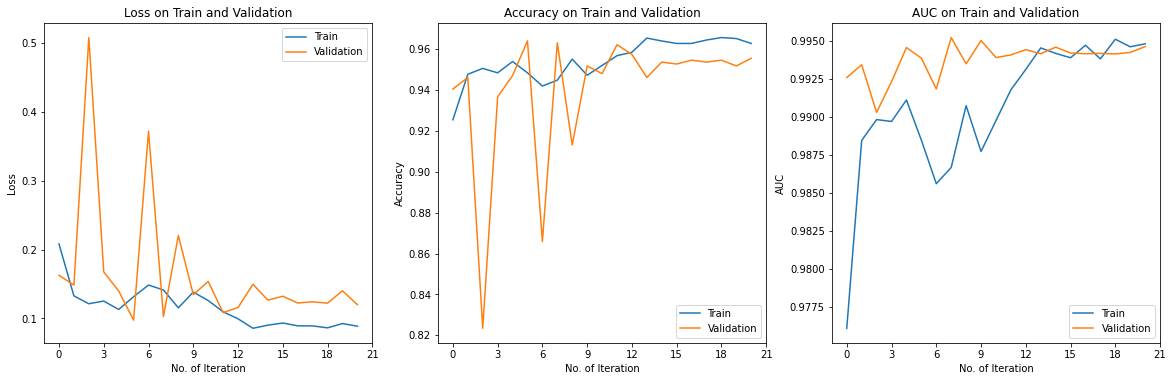

In [ ]:
plt.figure(figsize=(20, 20))

plt.subplot(3, 3, 1)
plt.plot(history.history["loss"], label="Train")
plt.plot(history.history["val_loss"], label="Validation")
plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
plt.xlabel("No. of Iteration")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss on Train and Validation")

plt.subplot(3, 3, 2)
plt.plot(history.history["accuracy"], label="Train")
plt.plot(history.history["val_accuracy"], label="Validation")
plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
plt.xlabel("No. of Iteration")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy on Train and Validation")

plt.subplot(3, 3, 3)
plt.plot(history.history["auc"], label="Train")
plt.plot(history.history["val_auc"], label="Validation")
plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
plt.xlabel("No. of Iteration")
plt.ylabel("AUC")
plt.legend()
plt.title("AUC on Train and Validation")

plt.show()

After a dozen epochs, loss function dropped to less than 0.1, while for accuracy and AUC it can be noted a stationary behaviour on the validation set.

AUC is taken into account to evaluate the model performance.

In [ ]:
print("AUC on train:", model.evaluate(x=train_generator, verbose=0)[2])
print("AUC on validation:", model.evaluate(x=valid_generator, verbose=0)[2])

AUC on train: 0.9935697317123413
AUC on validation: 0.9946162104606628


AUC is close to 1 for both train and validation set.

In [ ]:
y_pred = model.predict(test_generator)
y_test = test_generator.classes
auc_test = roc_auc_score(y_test, y_pred)
print("AUC on test:", auc_test)

AUC on test:  0.9721400394477318


AUC is close to 1 also for test set, meaning that the model is able to provide a reliable performance even with new data.

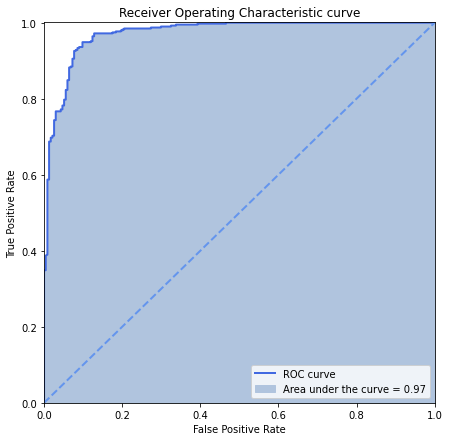

In [ ]:
fpr , tpr , thresholds = roc_curve (y_test, y_pred)
auc_keras = auc(fpr, tpr)

plt.figure(figsize=(7, 7))
line_width = 2
plt.plot(fpr, tpr, color="royalblue",
         lw=line_width, label="ROC curve")
plt.fill_between(x=fpr, y1=0, y2=tpr, color="lightsteelblue", label="Area under the curve = %0.2f" % auc_keras)
plt.plot([0, 1], [0, 1], color="cornflowerblue", lw=line_width, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.001])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic curve")
plt.legend(loc="lower right")
plt.show()

ROC curve reaches very soon the upper edge of the unit square.

Since the model only provides the posterior probability to belong to the class 1 (i.e. Pneumonia), it is not possible to generate a confusion matrix with this output. As a workaround a threshold, let's say 0.5, can be set: if the posterior probability is larger than 0.5 then the image belongs to class 1, otherwise it belongs to class 0.

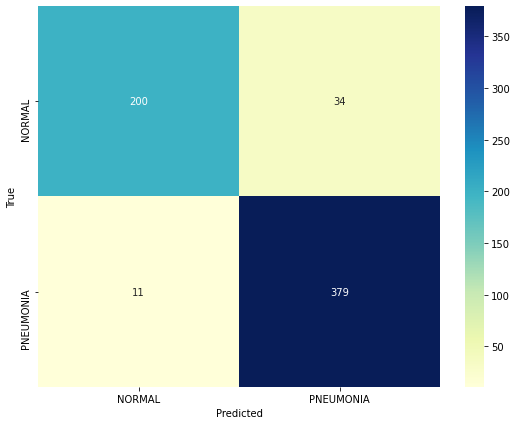

In [ ]:
threshold = 0.5
pred_test = (y_pred > threshold).astype("float")
cf_matrix = confusion_matrix(labels=y_test, predictions=pred_test)

fig, ax = plt.subplots(figsize=(9, 7))
heatmap(cf_matrix, annot=True, fmt="g", cmap="YlGnBu", xticklabels=["NORMAL", "PNEUMONIA"], yticklabels=["NORMAL", "PNEUMONIA"], )
plt.ylabel("True")
plt.xlabel("Predicted")
plt.show()

As expected, since the value for the AUC suggested a reliable model, the confusion matrix resembles a diagonal matrix.

## 5. Final words

The use of image generators and the architecture of the pre-trained model made respectively the pre-processing and the model definition uncomplicated. The enhancement of the validation set also played a part, since originally this set was too small to be considered reliable.

The model provided a brilliant performance for this dataset. AUC was close to 1 for all the three datasets, meaning that the model was able to adapt to the train data, but also capable to provide a sharp performance with brand new data.